In [1]:
import sys
import os

import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = "/home/tom/Documents/UNT/csce6260/projects/OpenPCDet"
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets.kitti.kitti_dataset import KittiDataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cfg_file = os.path.join(PROJECT_ROOT, "tools/cfgs/kitti_models/pointrcnn.yaml")
cfg_from_yaml_file(cfg_file, cfg)

dataset = KittiDataset(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    training=False
)

print("Dataset length:", len(dataset))

Dataset length: 3769


In [3]:
sample = dataset[0]
points = sample['points']
print("Points shape:", points.shape)
print("Frame ID:", sample['frame_id'])
print("Sample keys:", sample.keys())

Points shape: (16384, 4)
Frame ID: 000001
Sample keys: dict_keys(['frame_id', 'calib', 'gt_boxes', 'gt_boxes2d', 'points', 'images', 'lidar_aug_matrix', 'use_lead_xyz', 'image_shape'])


In [4]:
CLASS_COLORS = {
    1: (1, 0, 0),    # Car     (red)
    2: (0, 1, 0),    # Pedestrian (green)
    3: (0, 0, 1)     # Cyclist (blue)
}

def draw_gt_boxes(image, boxes2d, class_ids, class_names):
    img = image.copy()
    for (xmin, ymin, xmax, ymax), cid in zip(boxes2d, class_ids):
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        label = class_names[cid - 1]
        color_rgb = CLASS_COLORS.get(cid, (1, 1, 1))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color_rgb, 2)
        cv2.putText(img, label, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_rgb, 2)
    return img

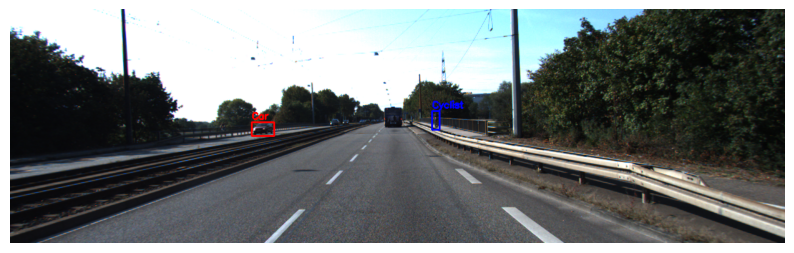

In [5]:
image = sample['images']
boxes2d = sample['gt_boxes2d']
class_ids = sample['gt_boxes'][:, -1].astype(int)
class_names = cfg.CLASS_NAMES

drawn = draw_gt_boxes(image, boxes2d, class_ids, class_names)

plt.figure(figsize=(10,6))
plt.imshow(drawn)
plt.axis("off")
plt.show()

In [6]:
points = sample['points'][:, :3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

z = points[:, 2]
z_norm = (z - z.min()) / (z.max() - z.min() + 1e-6)
colors = plt.cm.jet(z_norm)[:, :3]
pcd.colors = o3d.utility.Vector3dVector(colors)

gt_boxes = sample['gt_boxes']
boxes = []
for box in gt_boxes:
    x, y, z, dx, dy, dz, heading, class_idx = box
    class_idx = int(class_idx)
    obb = o3d.geometry.OrientedBoundingBox(
        center=[0, 0, 0],
        R=o3d.geometry.get_rotation_matrix_from_xyz([0, 0, heading]),
        extent=[dx, dy, dz]
    )
    obb.translate([x, y, z])
    obb.color = CLASS_COLORS.get(class_idx, (1, 1, 1))
    boxes.append(obb)

o3d.visualization.draw_geometries([pcd, *boxes])